In [1]:
### 常规分析包
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
### 其他
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
sns.color_palette(["#4a4a4a", "#00798c", "#d1495b", '#edae49', '#66a182'])

[(0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274)]

# 1. Accuaracy statistic

In [10]:
paths = [(0.00, 'NE_NA_NS_changed'), 
         (0.02, 'SE_SA_SS_changed_1'), (0.04, 'SE_SA_SS_changed_2'), (0.06, 'SE_SA_SS_changed_3'), (0.08, 'SE_SA_SS_changed_4'), (0.10, 'SE_SA_SS_changed_5'), 
         (0.12, 'HE_HA_HS_changed_1'), (0.14, 'HE_HA_HS_changed_2'), (0.16, 'HE_HA_HS_changed_3'), (0.18, 'HE_HA_HS_changed_4'), (0.20, 'HE_HA_HS_changed_5'),
         (0.10, 'LE_LA_LS_changed_1'), (0.10, 'LE_LA_LS_changed_2'), (0.10, 'LE_LA_LS_changed_3'), (0.10, 'LE_LA_LS_changed_4'), (0.10, 'LE_LA_LS_changed_5')]

import re
result = pd.DataFrame()
index = 0
for diff, path in paths:
    res = pd.read_csv("../simuData/"+path+".csv", index_col=0)
    res['Dataset_ID'] = res.index
    res.index = ['SimuData_'+str(i) for i in range(index, index+res.shape[0])]
    index += res.shape[0]
    res['Path'] = '../simuData/config_'+path.replace('_changed', '')+'/'
    res['Difference_in_Metabolic_background'] = diff
    # config
    cofig = eval(open('../simuData/config_'+path.replace('_changed', '')+'/config.txt', 'r').readline())
    res['Config_N_sample'] = cofig['N']
    res['Config_mean_env_trial0'] = cofig['MEAN_E0']
    res['Config_mean_env_trial1'] = cofig['MEAN_E1']
    res['Config_sigma_env_trial0'] = cofig['SIGMA_E0']
    res['Config_sigma_env_trial1'] = cofig['SIGMA_E1']
    res['Config_min_env'] = cofig['MIN_E']
    res['Config_max_env'] = cofig['MAX_E']
    res['Config_mean_age_trial0'] = cofig['MEAN_A0']
    res['Config_mean_age_trial1'] = cofig['MEAN_A1']
    res['Config_sigma_age_trial0'] = cofig['SIGMA_A0']
    res['Config_sigma_age_trial1'] = cofig['SIGMA_A1']
    res['Config_min_age'] = cofig['MIN_A']
    res['Config_max_age'] = cofig['MAX_A']
    res['Config_mean_sex_trial0'] = cofig['MEAN_S0']
    res['Config_mean_sex_trial1'] = cofig['MEAN_S1']
    res['Config_sigma_sex_trial0'] = cofig['SIGMA_S0']
    res['Config_sigma_sex_trial1'] = cofig['SIGMA_S1']
    res['Config_min_sex'] = cofig['MIN_S']
    res['Config_max_sex'] = cofig['MAX_S']
    res['Config_mean_noise'] = cofig['MEAN_N']
    res['Config_sigma_noise'] = cofig['SIGMA_N']
    res['Config_min_noise'] = cofig['MIN_N']
    res['Config_max_noise'] = cofig['MAX_N']
    res['Config_trial_effect_env'] = cofig['LE_E']
    res['Config_trial_effect_age'] = cofig['LE_A']
    res['Config_trial_effect_sex'] = cofig['LE_S']
    res['Config_abundance_weights'] = [cofig['Weights_proportion'] for i in res.index]
    # caliper ratio
    calipers = []
    ratios = []
    for datasetid in res['Dataset_ID']:
        summary = ''.join(open('../simuData/config_'+path.replace('_changed', '')+'/'+datasetid[1:]+'/PSM_Summary_report.txt', 'r').readlines())
        caliper, ratio = re.search('caliper = ([\w\W]+?), ratio = ([\w\W]+?)\)', summary).groups()
        calipers.append(float(caliper))
        ratios.append(int(ratio))
    res['Caliper'] = calipers
    res['Ratio'] = ratios
    # balance
    balances = []
    for datasetid in res['Dataset_ID']:
        summary = pd.read_csv('../simuData/config_'+path.replace('_changed', '')+'/'+datasetid[1:]+'/Summary_of_Balance_for_All_Data.tsv', 
                              index_col=0, sep='\t')
        balances.append(summary.loc['distance', 'Std. Mean Diff.'])
    res['Balance_of_PS'] = balances
    # match count
    pair_counts = []
    for datasetid in res['Dataset_ID']:
        matched = pd.read_csv('../simuData/config_'+path.replace('_changed', '')+'/'+datasetid[1:]+'/PSM_Matched_Pairs.tsv', index_col=0, sep='\t')
        pair_count = matched.shape[0] - list(matched['V1']).count('NA_character_')
        pair_counts.append(pair_count)
    res['Pairs'] = pair_counts
    # concat
    result = pd.concat([result, res], axis=0, sort=False)

columns = list(result.columns[8:])
columns.extend(list(result.columns[:8]))
result = result.loc[:, columns]
result.to_csv('../20230718_Results/Figure 2AB. Simulated dataset.tsv', sep='\t')
result.head(2)

,Dataset_ID,Path,Difference_in_Metabolic_background,Config_N_sample,Config_mean_env_trial0,Config_mean_env_trial1,Config_sigma_env_trial0,Config_sigma_env_trial1,Config_min_env,Config_max_env,...,Balance_of_PS,Pairs,Accuracy,Precision,Recall,F1,psm-Accuracy,psm-Precision,psm-Recall,psm-F1
SimuData_0,s0,../simuData/config_NE_NA_NS/,0.0,100,0.5,0.5,0.2,0.2,0,1,...,0.266487,87,0.95,1.0,0.90,0.947368,0.98,1.0,0.96,0.979592
SimuData_1,s1,../simuData/config_NE_NA_NS/,0.0,100,0.5,0.5,0.2,0.2,0,1,...,0.151810,88,0.99,1.0,0.98,0.989899,0.99,1.0,0.98,0.989899


# 2. Figure 2A

In [3]:
data = pd.read_csv('../20230718_Results/Figure 2AB. Simulated dataset.tsv', sep='\t', index_col=0)
data

,Dataset_ID,Path,Difference_in_Metabolic_background,Config_N_sample,Config_mean_env_trial0,Config_mean_env_trial1,Config_sigma_env_trial0,Config_sigma_env_trial1,Config_min_env,Config_max_env,...,Balance_of_PS,Pairs,Accuracy,Precision,Recall,F1,psm-Accuracy,psm-Precision,psm-Recall,psm-F1
SimuData_0,s0,../simuData/config_NE_NA_NS/,0.0,100,0.50,0.50,0.2,0.2,0,1,...,0.266487,87,0.95,1.000000,0.90,0.947368,0.98,1.000000,0.96,0.979592
SimuData_1,s1,../simuData/config_NE_NA_NS/,0.0,100,0.50,0.50,0.2,0.2,0,1,...,0.151810,88,0.99,1.000000,0.98,0.989899,0.99,1.000000,0.98,0.989899
SimuData_2,s2,../simuData/config_NE_NA_NS/,0.0,100,0.50,0.50,0.2,0.2,0,1,...,0.093882,88,0.97,1.000000,0.94,0.969072,0.88,1.000000,0.76,0.863636
SimuData_3,s3,../simuData/config_NE_NA_NS/,0.0,100,0.50,0.50,0.2,0.2,0,1,...,0.272474,91,0.98,1.000000,0.96,0.979592,0.96,1.000000,0.92,0.958333
SimuData_4,s4,../simuData/config_NE_NA_NS/,0.0,100,0.50,0.50,0.2,0.2,0,1,...,0.209504,87,0.98,1.000000,0.96,0.979592,0.97,1.000000,0.94,0.969072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SimuData_795,s45,../simuData/config_LE_LA_LS_5/,0.1,100,0.45,0.55,0.2,0.2,0,1,...,1.919462,100,0.51,0.505155,0.98,0.666667,0.90,1.000000,0.80,0.888889
SimuData_796,s46,../simuData/config_LE_LA_LS_5/,0.1,100,0.45,0.55,0.2,0.2,0,1,...,2.198466,91,0.50,0.500000,1.00,0.666667,0.94,1.000000,0.88,0.936170
SimuData_797,s47,../simuData/config_LE_LA_LS_5/,0.1,100,0.45,0.55,0.2,0.2,0,1,...,1.480329,92,0.51,0.505051,1.00,0.671141,0.98,1.000000,0.96,0.979592
SimuData_798,s48,../simuData/config_LE_LA_LS_5/,0.1,100,0.45,0.55,0.2,0.2,0,1,...,1.795943,73,0.50,0.500000,1.00,0.666667,0.92,0.875000,0.98,0.924528


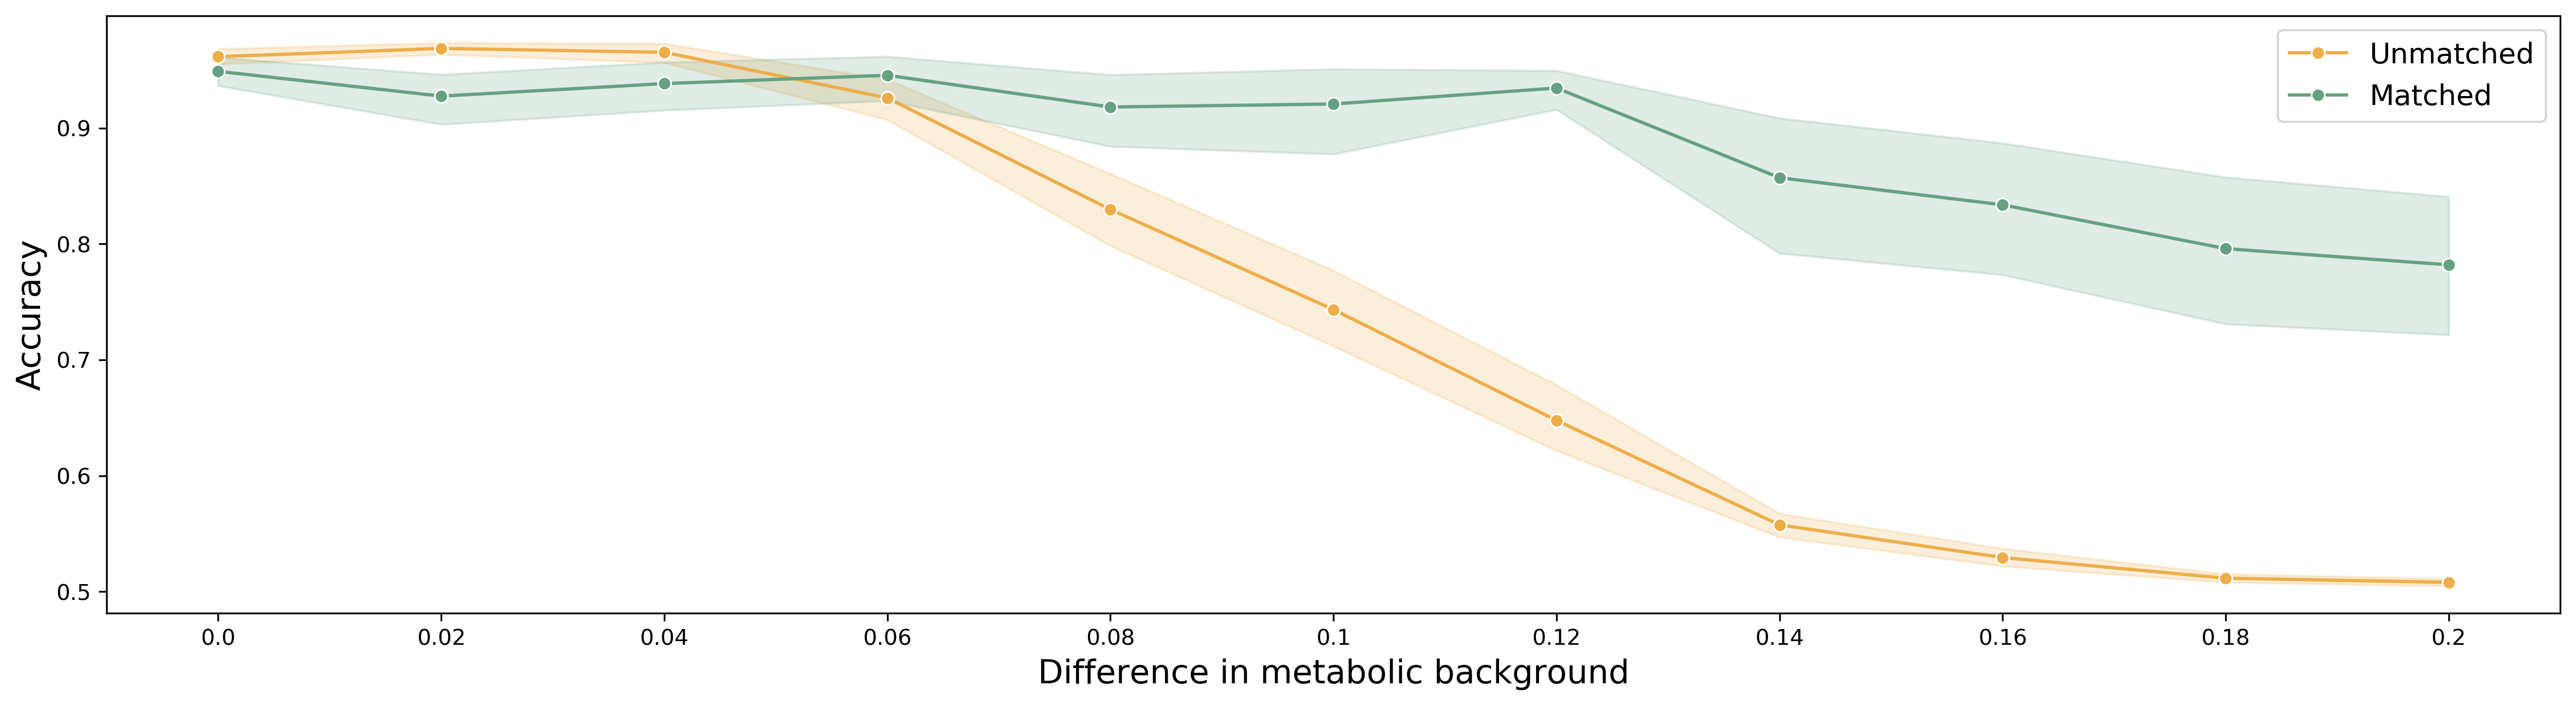

In [27]:
#sns.set_context("paper")
plotdata = data.loc[data['Config_trial_effect_env']==0, :]
fig = plt.figure(figsize=(20, 5), dpi=300)
# Accuracy
_ = sns.lineplot(x="Difference_in_Metabolic_background", y="Accuracy", data=plotdata, color='#edae49', marker='o', sort=False, label='Unmatched')
_ = sns.lineplot(x="Difference_in_Metabolic_background", y="psm-Accuracy", data=plotdata, color='#66a182', marker='o', sort=False, label='Matched')
_ = plt.xticks([0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20], [0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20])
_ = plt.xlabel('Difference in metabolic background', fontsize=15)
_ = plt.ylabel('Accuracy', fontsize=15)
_ = plt.legend(fontsize=13)
_ = plt.show()
_ = fig.savefig('../20230718_Results/Figure 2A_Accuracy.pdf', dpi=300)

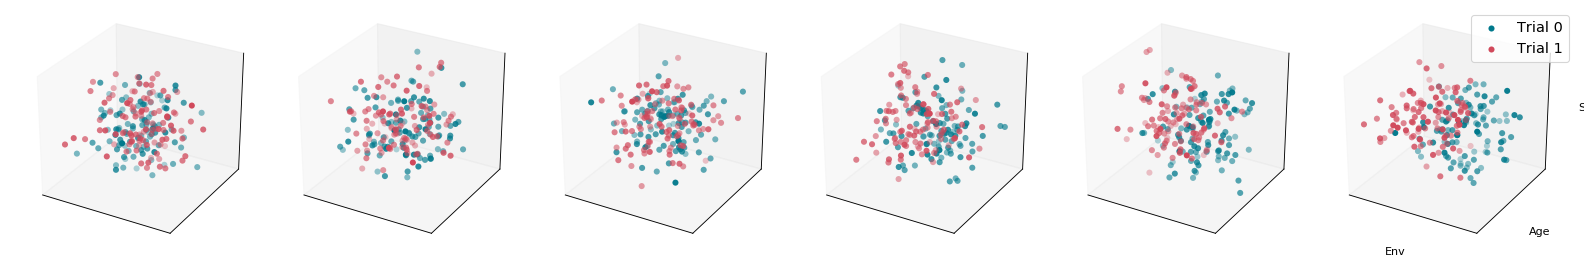

In [32]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 3), dpi=80)
size = 30
gs = gridspec.GridSpec(1, 6, left=0.01, right=0.99, top=1, bottom=0.0, wspace=0.0, hspace=0.1)

ax1 = plt.subplot(gs[:, 0], projection='3d')
meta = pd.read_csv('../simuData/config_NE_NA_NS/0/metadata.csv', index_col=0)
_ = ax1.scatter(meta.loc[meta['Group']==0, 'Environment'], meta.loc[meta['Group']==0, 'Age'], meta.loc[meta['Group']==0, 'Sex'], s=size, color='#00798c', linewidths=0)
_ = ax1.scatter(meta.loc[meta['Group']==1, 'Environment'], meta.loc[meta['Group']==1, 'Age'], meta.loc[meta['Group']==1, 'Sex'], s=size, color='#d1495b', linewidths=0)
_ = ax1.view_init(elev=30, azim=120)# 仰角, 方位角
_ = ax1.set_xticks([])
_ = ax1.set_yticks([])
_ = ax1.set_zticks([])

ax2 = plt.subplot(gs[:, 1], projection='3d')
meta = pd.read_csv('../simuData/config_SE_SA_SS_2/0/metadata.csv', index_col=0)
_ = ax2.scatter(meta.loc[meta['Group']==0, 'Environment'], meta.loc[meta['Group']==0, 'Age'], meta.loc[meta['Group']==0, 'Sex'], s=size, color='#00798c', linewidths=0)
_ = ax2.scatter(meta.loc[meta['Group']==1, 'Environment'], meta.loc[meta['Group']==1, 'Age'], meta.loc[meta['Group']==1, 'Sex'], s=size, color='#d1495b', linewidths=0)
_ = ax2.view_init(elev=30, azim=120)# 仰角, 方位角
_ = ax2.set_xticks([])
_ = ax2.set_yticks([])
_ = ax2.set_zticks([])

ax2 = plt.subplot(gs[:, 2], projection='3d')
meta = pd.read_csv('../simuData/config_SE_SA_SS_4/0/metadata.csv', index_col=0)
_ = ax2.scatter(meta.loc[meta['Group']==0, 'Environment'], meta.loc[meta['Group']==0, 'Age'], meta.loc[meta['Group']==0, 'Sex'], s=size, color='#00798c', linewidths=0)
_ = ax2.scatter(meta.loc[meta['Group']==1, 'Environment'], meta.loc[meta['Group']==1, 'Age'], meta.loc[meta['Group']==1, 'Sex'], s=size, color='#d1495b', linewidths=0)
_ = ax2.view_init(elev=30, azim=120)# 仰角, 方位角
_ = ax2.set_xticks([])
_ = ax2.set_yticks([])
_ = ax2.set_zticks([])

ax2 = plt.subplot(gs[:, 3], projection='3d')
meta = pd.read_csv('../simuData/config_HE_HA_HS_1/0/metadata.csv', index_col=0)
_ = ax2.scatter(meta.loc[meta['Group']==0, 'Environment'], meta.loc[meta['Group']==0, 'Age'], meta.loc[meta['Group']==0, 'Sex'], s=size, color='#00798c', linewidths=0)
_ = ax2.scatter(meta.loc[meta['Group']==1, 'Environment'], meta.loc[meta['Group']==1, 'Age'], meta.loc[meta['Group']==1, 'Sex'], s=size, color='#d1495b', linewidths=0)
_ = ax2.view_init(elev=30, azim=120)# 仰角, 方位角
_ = ax2.set_xticks([])
_ = ax2.set_yticks([])
_ = ax2.set_zticks([])

ax2 = plt.subplot(gs[:, 4], projection='3d')
meta = pd.read_csv('../simuData/config_HE_HA_HS_3/0/metadata.csv', index_col=0)
_ = ax2.scatter(meta.loc[meta['Group']==0, 'Environment'], meta.loc[meta['Group']==0, 'Age'], meta.loc[meta['Group']==0, 'Sex'], s=size, color='#00798c', linewidths=0)
_ = ax2.scatter(meta.loc[meta['Group']==1, 'Environment'], meta.loc[meta['Group']==1, 'Age'], meta.loc[meta['Group']==1, 'Sex'], s=size, color='#d1495b', linewidths=0)
_ = ax2.view_init(elev=30, azim=120)# 仰角, 方位角
_ = ax2.set_xticks([])
_ = ax2.set_yticks([])
_ = ax2.set_zticks([])

ax2 = plt.subplot(gs[:, 5], projection='3d')
meta = pd.read_csv('../simuData/config_HE_HA_HS_5/0/metadata.csv', index_col=0)
_ = ax2.scatter(meta.loc[meta['Group']==0, 'Environment'], meta.loc[meta['Group']==0, 'Age'], meta.loc[meta['Group']==0, 'Sex'], s=size, color='#00798c', label='Trial 0', linewidths=0)
_ = ax2.scatter(meta.loc[meta['Group']==1, 'Environment'], meta.loc[meta['Group']==1, 'Age'], meta.loc[meta['Group']==1, 'Sex'], s=size, color='#d1495b', label='Trial 1', linewidths=0)
_ = ax2.view_init(elev=30, azim=120)# 仰角, 方位角
_ = ax2.set_xticks([])
_ = ax2.set_yticks([])
_ = ax2.set_zticks([])
_ = ax2.set_xlabel('Env')
_ = ax2.set_ylabel('Age')
_ = ax2.set_zlabel('Sex')
_ = plt.legend(fontsize=13)

_ = fig.savefig('../20230718_Results/Figure 2A_3DScatter.pdf', dpi=300)

# 3. Figure S3A

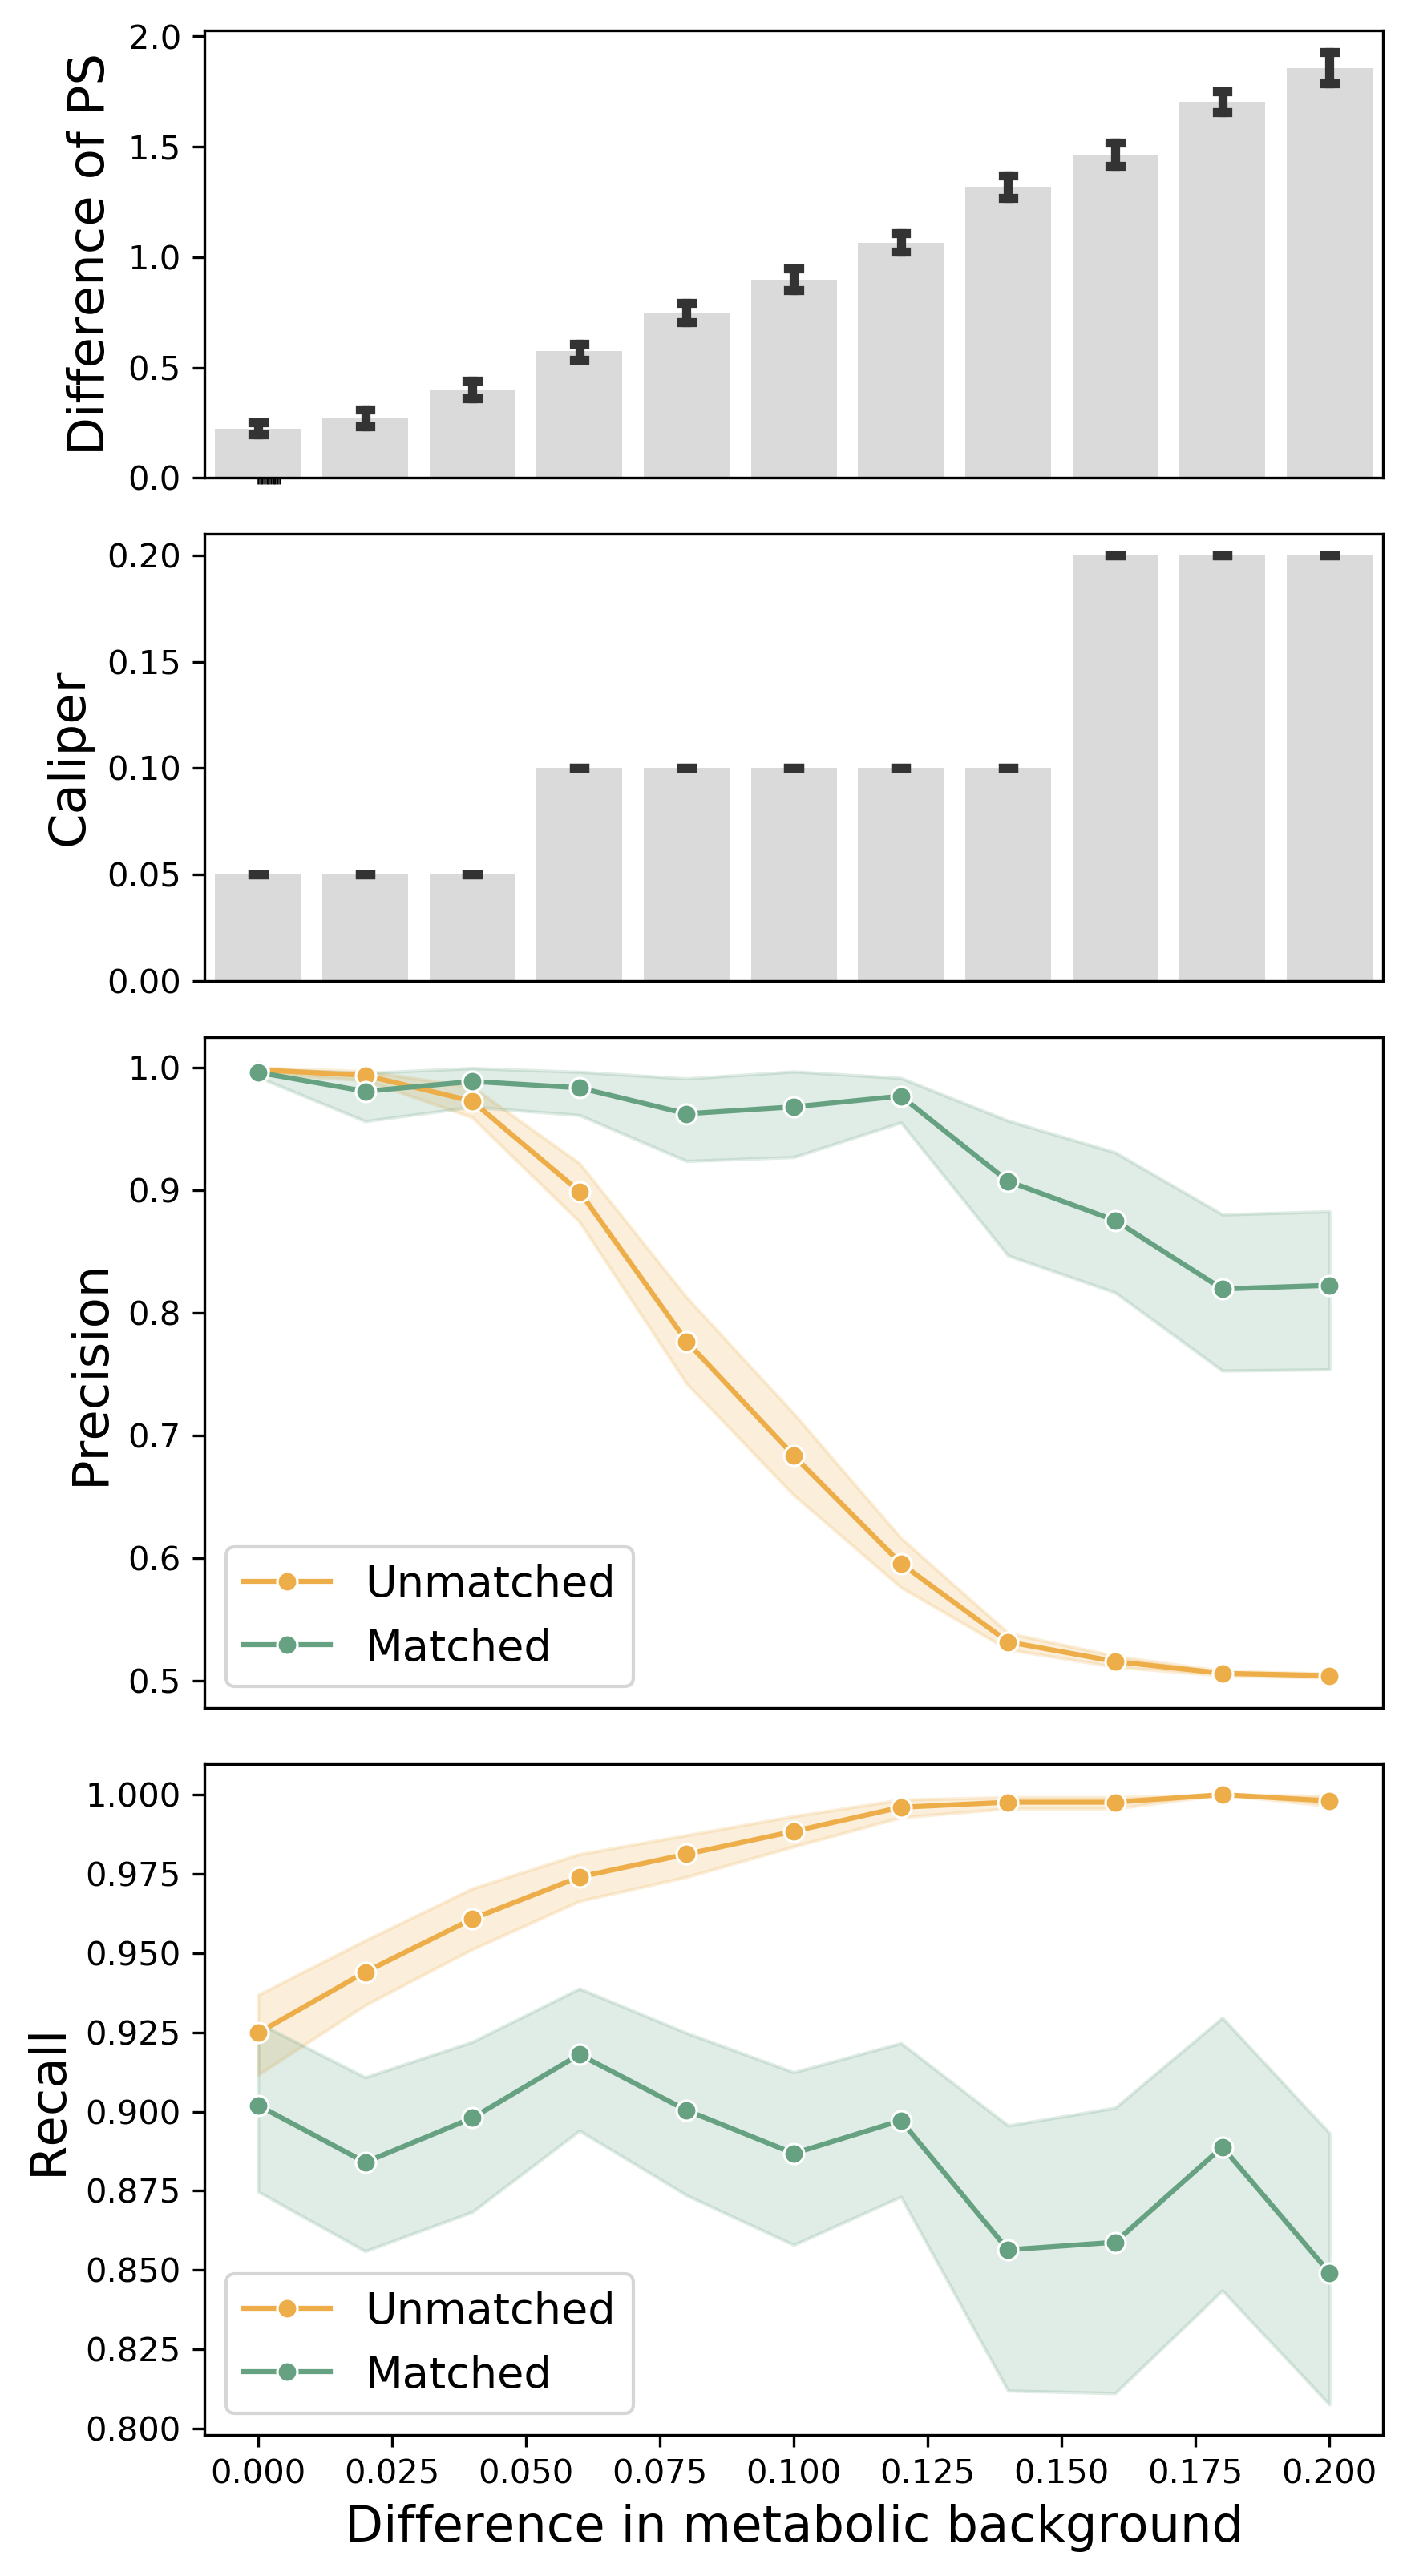

In [55]:
plotdata = data.loc[data['Config_trial_effect_env']==0, :]

fig = plt.figure(figsize=(5, 10), dpi=300)
gs = gridspec.GridSpec(4, 1, left=0.01, right=0.99, top=1, bottom=0.0, wspace=0.0, hspace=0.1, height_ratios=[0.2, 0.2, 0.3, 0.3])

# Balance_of_PS
ax1 = plt.subplot(gs[0, 0])
_ = sns.barplot(x="Difference_in_Metabolic_background", y='Balance_of_PS', data=plotdata, ax=ax1, alpha=0.2, color='#4a4a4a', 
                capsize=.1, errcolor=".2", linewidth=0.5, )
_ = ax1.set_xticks([])
_ = plt.xlabel('')
_ = plt.ylabel('Difference of PS', fontsize=15)

# Caliper
ax2 = plt.subplot(gs[1, 0])
_ = sns.barplot(x="Difference_in_Metabolic_background", y='Caliper', data=plotdata, ax=ax2, alpha=0.2, color='#4a4a4a', 
                capsize=.1, errcolor=".2", linewidth=0.5, )
_ = ax2.set_xticks([])
_ = plt.xlabel('')
_ = plt.ylabel('Caliper', fontsize=15)

# Precision
ax3 = plt.subplot(gs[2, 0])
_ = sns.lineplot(x="Difference_in_Metabolic_background", y="Precision", data=plotdata, color='#edae49', marker='o', ax=ax3, sort=False, label='Unmatched')
_ = sns.lineplot(x="Difference_in_Metabolic_background", y="psm-Precision", data=plotdata, color='#66a182', marker='o', ax=ax3, sort=False, label='Matched')
_ = plt.legend(fontsize=13)
_ = ax3.set_xticks([])
_ = plt.xlabel('')
_ = plt.ylabel('Precision', fontsize=15)

# Recall
ax4 = plt.subplot(gs[3, 0])
_ = sns.lineplot(x="Difference_in_Metabolic_background", y="Recall", data=plotdata, color='#edae49', marker='o', ax=ax4, sort=False, label='Unmatched')
_ = sns.lineplot(x="Difference_in_Metabolic_background", y="psm-Recall", data=plotdata, color='#66a182', marker='o', ax=ax4, sort=False, label='Matched')
_ = plt.legend(fontsize=13)
_ = ax1.set_xticks([0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20], [0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20])
_ = plt.ylabel('Recall', fontsize=15)
_ = plt.xlabel('Difference in metabolic background', fontsize=15)
_ = plt.show()

_ = fig.savefig('../20230718_Results/Figure S3A.pdf', dpi=300)

# 4. Figure 2B

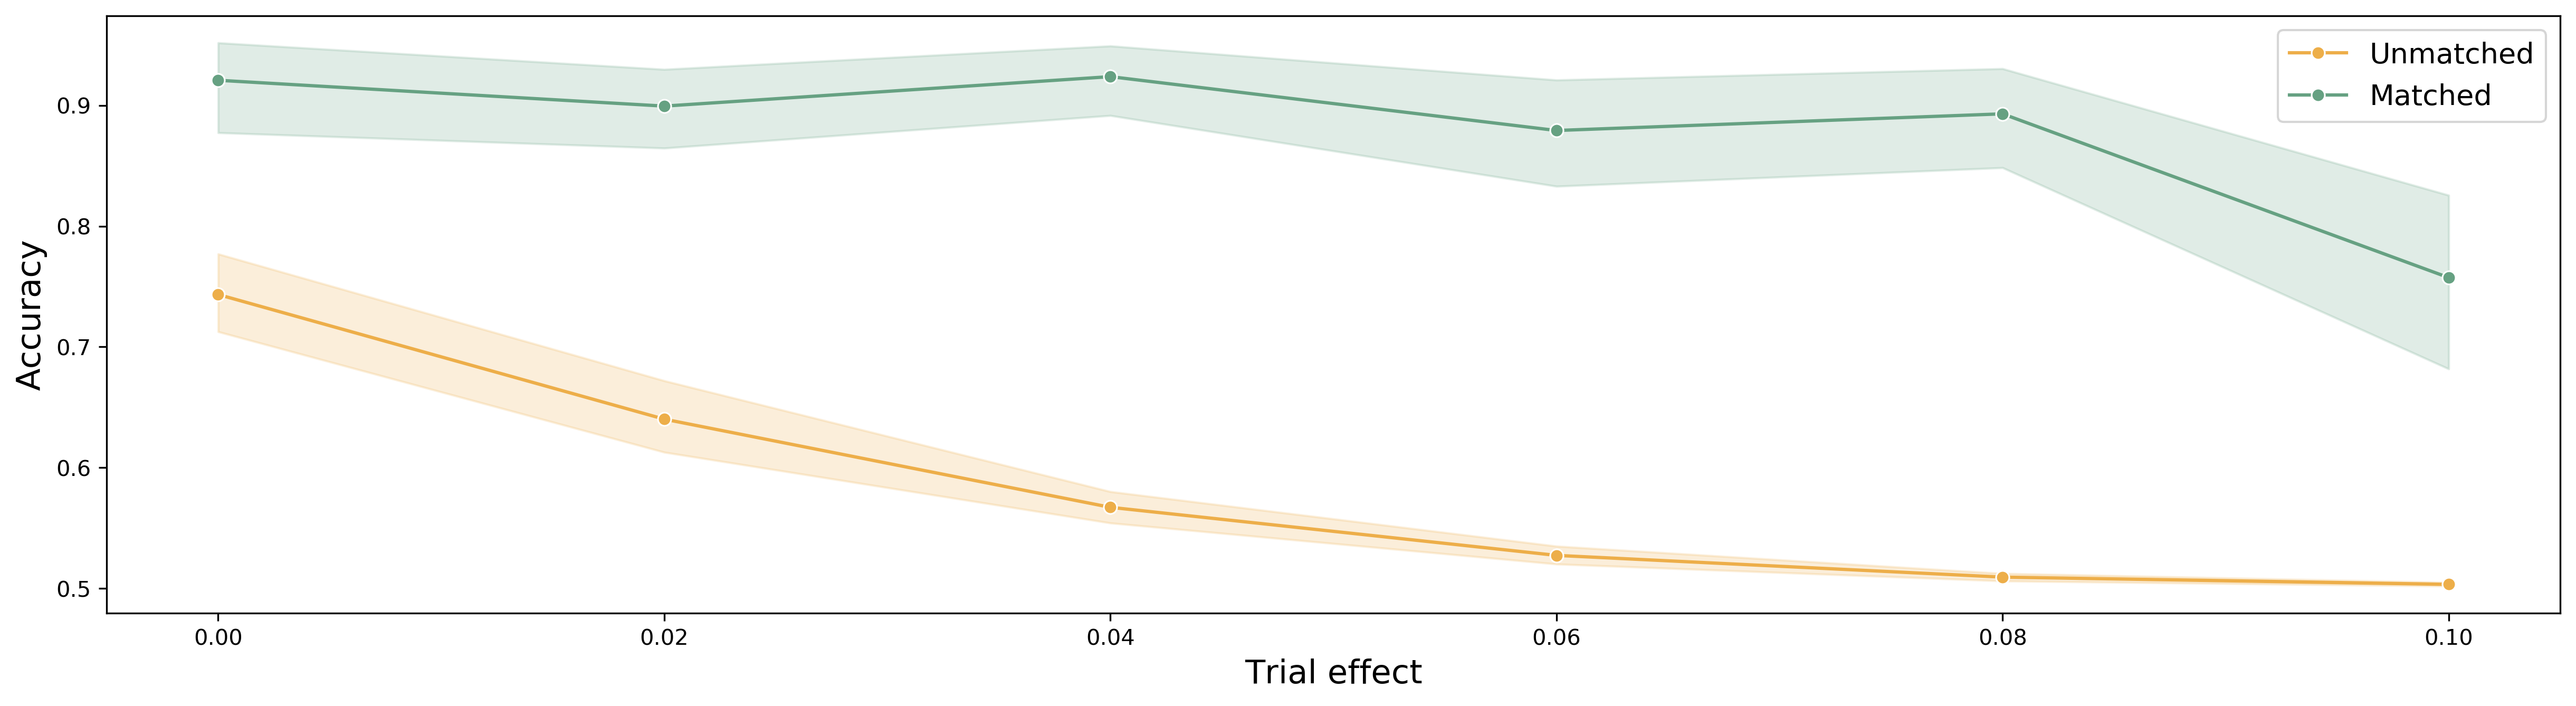

In [33]:
plotdata = data.loc[data['Difference_in_Metabolic_background']==0.1, :]
fig = plt.figure(figsize=(20, 5), dpi=300)
# Accuracy
_ = sns.lineplot(x="Config_trial_effect_env", y="Accuracy", data=plotdata, color='#edae49', marker='o', sort=False, label='Unmatched')
_ = sns.lineplot(x="Config_trial_effect_env", y="psm-Accuracy", data=plotdata, color='#66a182', marker='o', sort=False, label='Matched')
#_ = plt.xticks([0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20], [0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20])
_ = plt.xlabel('Trial effect', fontsize=15)
_ = plt.ylabel('Accuracy', fontsize=15)
_ = plt.legend(fontsize=13)
_ = plt.show()
_ = fig.savefig('../20230718_Results/Figure 2B_Accuracy.pdf', dpi=300)

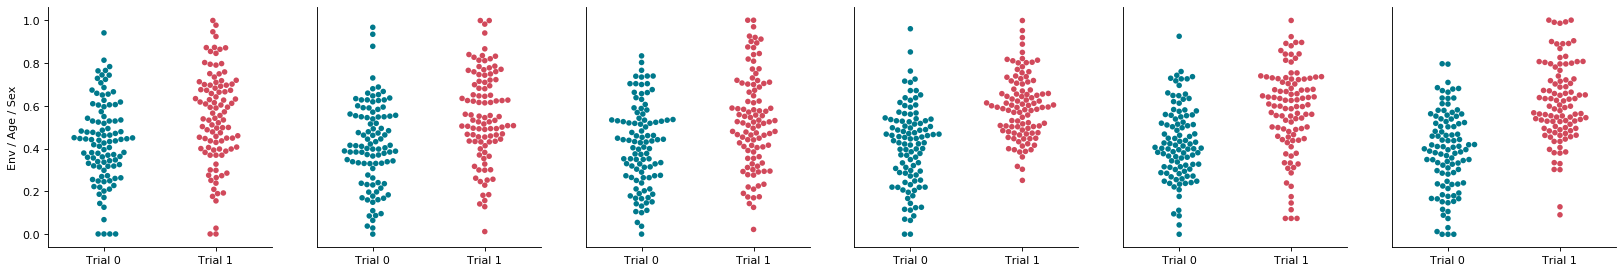

In [53]:
fig = plt.figure(figsize=(20, 3), dpi=80)
size = 5
gs = gridspec.GridSpec(1, 6, left=0.01, right=0.99, top=1, bottom=0.0, wspace=0.2, hspace=0.1)

ax1 = plt.subplot(gs[:, 0])
meta = pd.read_csv('../simuData/config_SE_SA_SS_5/0/metadata.csv', index_col=0)
_ = sns.swarmplot(data=meta, x="Group", y="Environment", s=size, palette=['#00798c', '#d1495b'])
_ = ax1.spines['top'].set_visible(False)
_ = ax1.spines['right'].set_visible(False)
_ = ax1.set_ylabel('Env / Age / Sex')
_ = ax1.set_xlabel('')
_ = ax1.set_xticklabels(['Trial 0', 'Trial 1'])

ax2 = plt.subplot(gs[:, 1])
meta = pd.read_csv('../simuData/config_LE_LA_LS_1/0/metadata.csv', index_col=0)
_ = sns.swarmplot(data=meta, x="Group", y="Environment", s=size, palette=['#00798c', '#d1495b'])
_ = ax2.spines['top'].set_visible(False)
_ = ax2.spines['right'].set_visible(False)
_ = ax2.get_yaxis().set_visible(False)
_ = ax2.set_xlabel('')
_ = ax2.set_xticklabels(['Trial 0', 'Trial 1'])

ax3 = plt.subplot(gs[:, 2])
meta = pd.read_csv('../simuData/config_LE_LA_LS_2/0/metadata.csv', index_col=0)
_ = sns.swarmplot(data=meta, x="Group", y="Environment", s=size, palette=['#00798c', '#d1495b'])
_ = ax3.spines['top'].set_visible(False)
_ = ax3.spines['right'].set_visible(False)
_ = ax3.get_yaxis().set_visible(False)
_ = ax3.set_xlabel('')
_ = ax3.set_xticklabels(['Trial 0', 'Trial 1'])

ax4 = plt.subplot(gs[:, 3])
meta = pd.read_csv('../simuData/config_LE_LA_LS_3/0/metadata.csv', index_col=0)
_ = sns.swarmplot(data=meta, x="Group", y="Environment", s=size, palette=['#00798c', '#d1495b'])
_ = ax4.spines['top'].set_visible(False)
_ = ax4.spines['right'].set_visible(False)
_ = ax4.get_yaxis().set_visible(False)
_ = ax4.set_xlabel('')
_ = ax4.set_xticklabels(['Trial 0', 'Trial 1'])

ax5 = plt.subplot(gs[:, 4])
meta = pd.read_csv('../simuData/config_LE_LA_LS_4/0/metadata.csv', index_col=0)
_ = sns.swarmplot(data=meta, x="Group", y="Environment", s=size, palette=['#00798c', '#d1495b'])
_ = ax5.spines['top'].set_visible(False)
_ = ax5.spines['right'].set_visible(False)
_ = ax5.get_yaxis().set_visible(False)
_ = ax5.set_xlabel('')
_ = ax5.set_xticklabels(['Trial 0', 'Trial 1'])

ax6 = plt.subplot(gs[:, 5])
meta = pd.read_csv('../simuData/config_LE_LA_LS_5/0/metadata.csv', index_col=0)
_ = sns.swarmplot(data=meta, x="Group", y="Environment", s=size, palette=['#00798c', '#d1495b'])
_ = ax6.spines['top'].set_visible(False)
_ = ax6.spines['right'].set_visible(False)
_ = ax6.get_yaxis().set_visible(False)
_ = ax6.set_xlabel('')
_ = ax6.set_xticklabels(['Trial 0', 'Trial 1'])

_ = fig.savefig('../20230718_Results/Figure 2B_Scatter.pdf', dpi=300)

# 5. Figure S3B

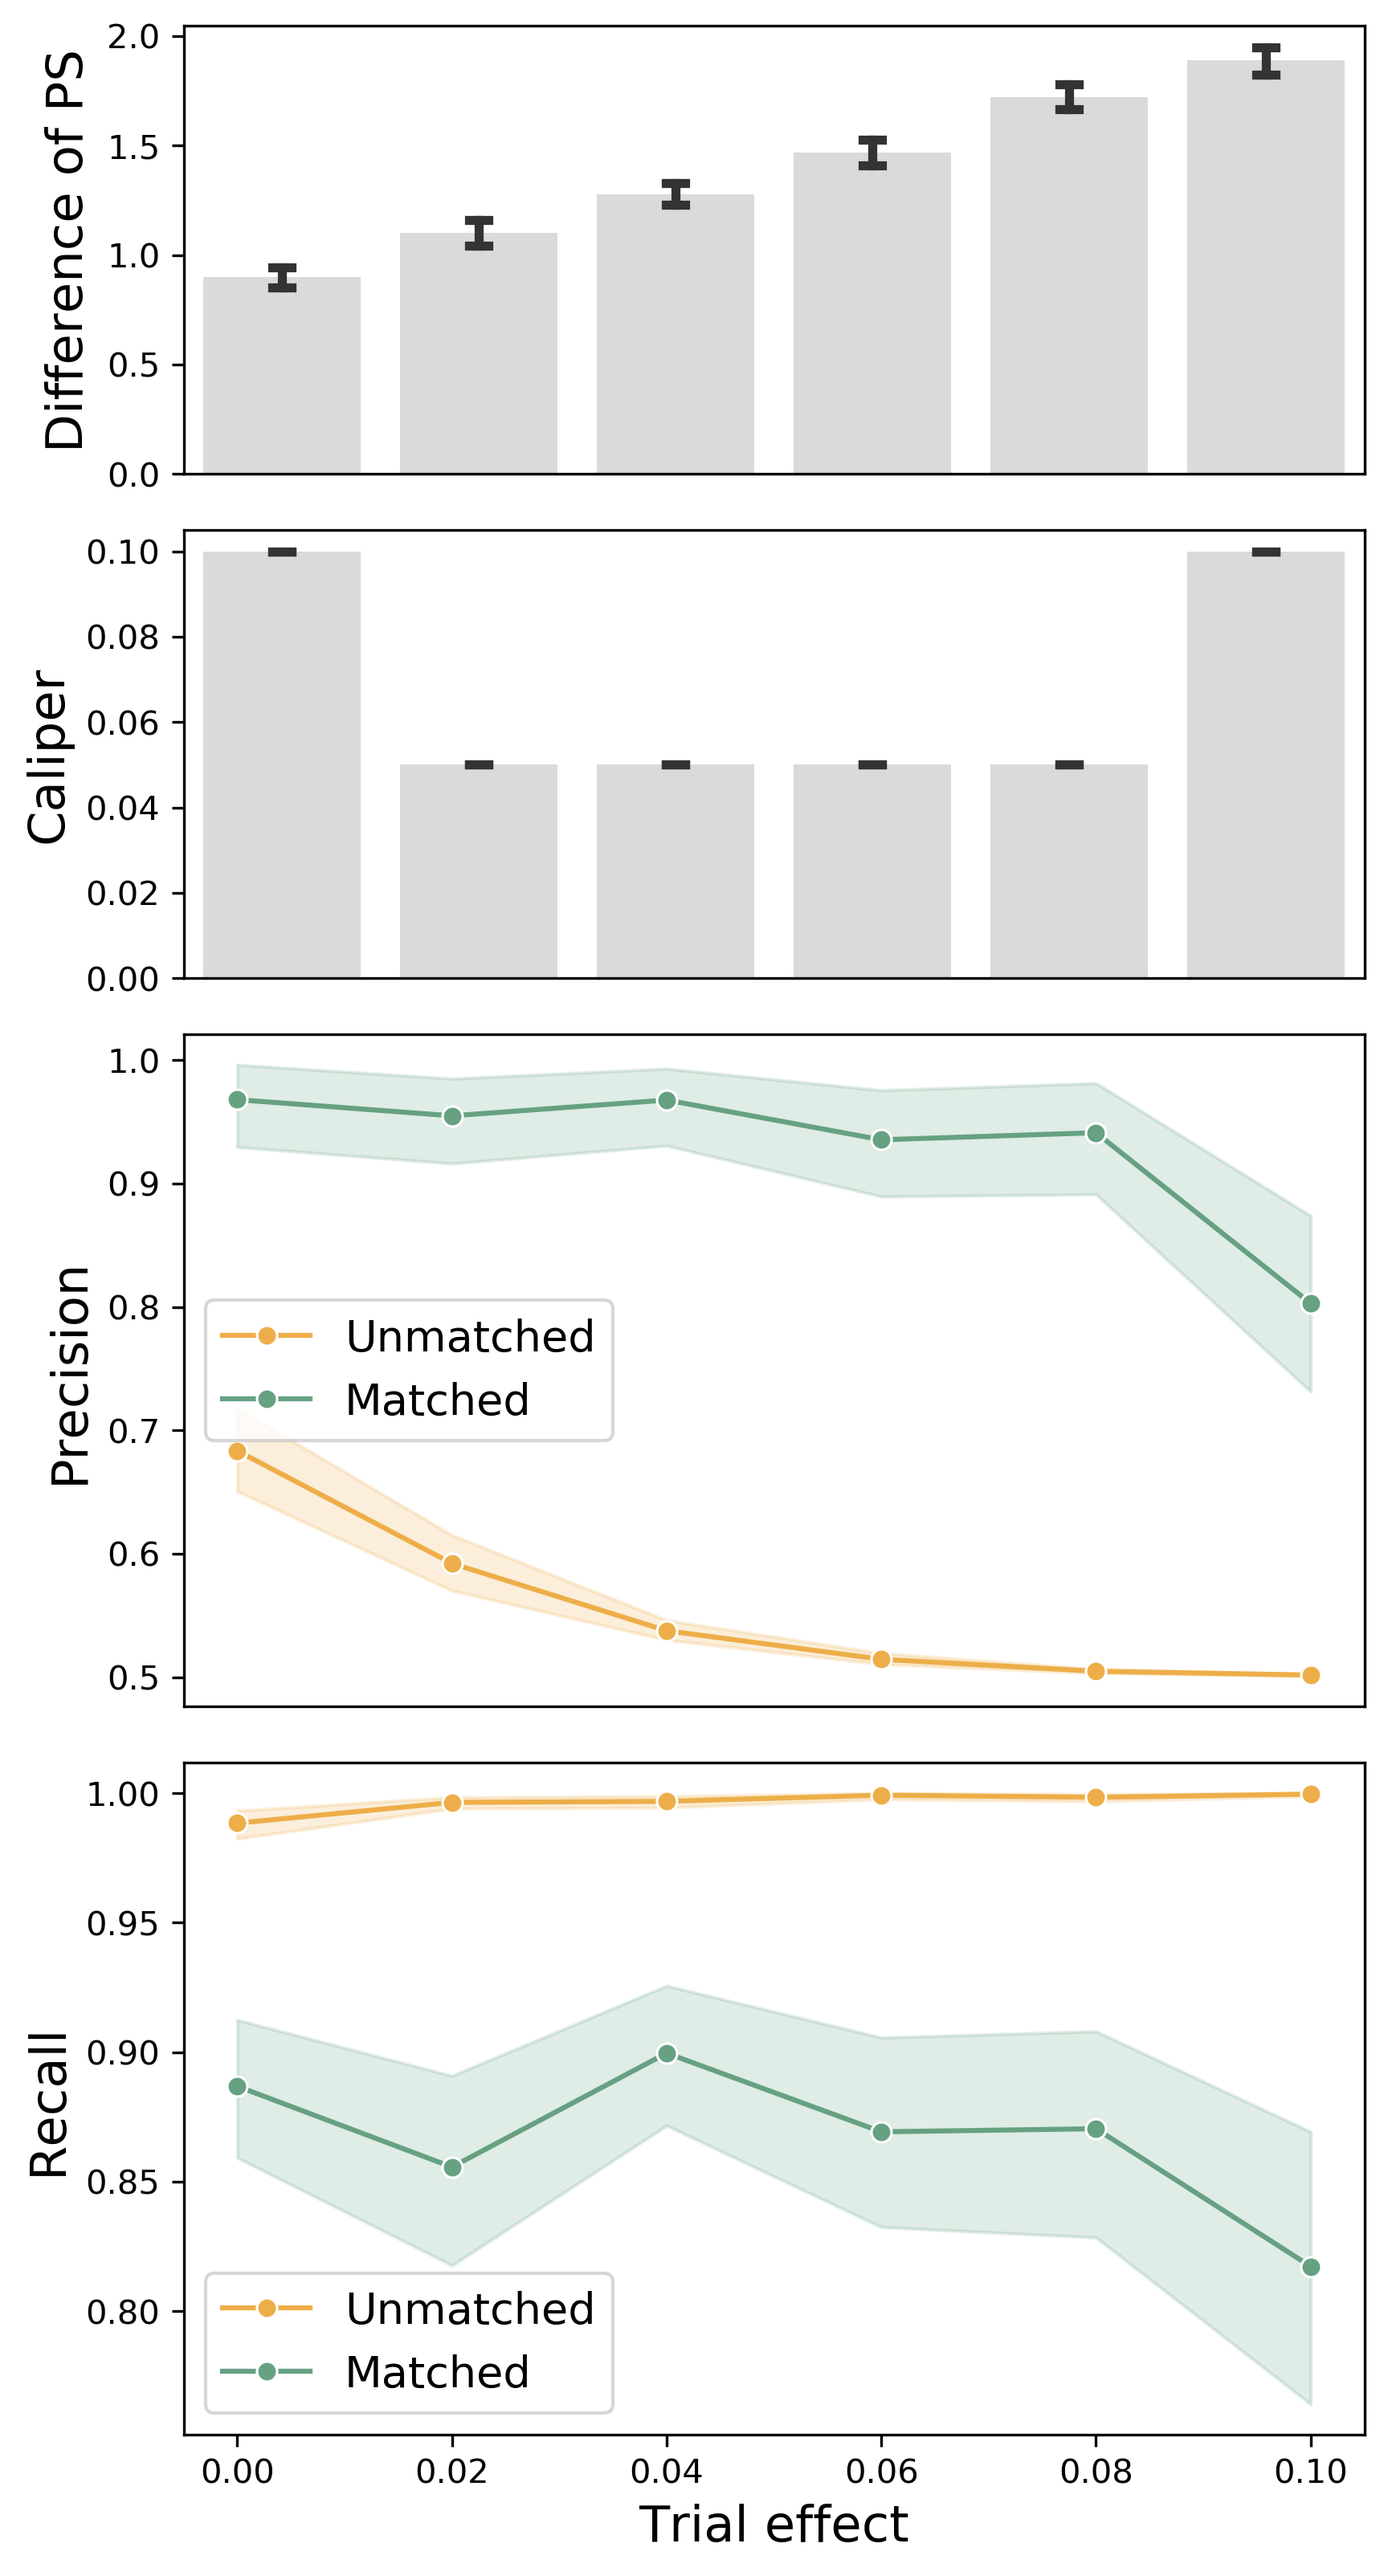

In [56]:
plotdata = data.loc[data['Difference_in_Metabolic_background']==0.1, :]

fig = plt.figure(figsize=(5, 10), dpi=300)
gs = gridspec.GridSpec(4, 1, left=0.01, right=0.99, top=1, bottom=0.0, wspace=0.0, hspace=0.1, height_ratios=[0.2, 0.2, 0.3, 0.3])

# Balance_of_PS
ax1 = plt.subplot(gs[0, 0])
_ = sns.barplot(x="Config_trial_effect_env", y='Balance_of_PS', data=plotdata, ax=ax1, alpha=0.2, color='#4a4a4a', 
                capsize=.1, errcolor=".2", linewidth=0.5, )
_ = ax1.set_xticks([])
_ = plt.xlabel('')
_ = plt.ylabel('Difference of PS', fontsize=15)

# Caliper
ax2 = plt.subplot(gs[1, 0])
_ = sns.barplot(x="Config_trial_effect_env", y='Caliper', data=plotdata, ax=ax2, alpha=0.2, color='#4a4a4a', 
                capsize=.1, errcolor=".2", linewidth=0.5, )
_ = ax2.set_xticks([])
_ = plt.xlabel('')
_ = plt.ylabel('Caliper', fontsize=15)

# Precision
ax3 = plt.subplot(gs[2, 0])
_ = sns.lineplot(x="Config_trial_effect_env", y="Precision", data=plotdata, color='#edae49', marker='o', ax=ax3, sort=False, label='Unmatched')
_ = sns.lineplot(x="Config_trial_effect_env", y="psm-Precision", data=plotdata, color='#66a182', marker='o', ax=ax3, sort=False, label='Matched')
_ = plt.legend(fontsize=13)
_ = ax3.set_xticks([])
_ = plt.xlabel('')
_ = plt.ylabel('Precision', fontsize=15)

# Recall
ax4 = plt.subplot(gs[3, 0])
_ = sns.lineplot(x="Config_trial_effect_env", y="Recall", data=plotdata, color='#edae49', marker='o', ax=ax4, sort=False, label='Unmatched')
_ = sns.lineplot(x="Config_trial_effect_env", y="psm-Recall", data=plotdata, color='#66a182', marker='o', ax=ax4, sort=False, label='Matched')
_ = plt.legend(fontsize=13)
_ = plt.ylabel('Recall', fontsize=15)
_ = plt.xlabel('Trial effect', fontsize=15)
_ = plt.show()

_ = fig.savefig('../20230718_Results/Figure S3B.pdf', dpi=300)